In [1]:
import datetime
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from collections import defaultdict
from itertools import repeat, combinations
from pandarallel import pandarallel
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, plot_heatmap,
    get_cols, insert_row_number
)
from utils.extraction_helpers import read_file
from utils.feature_group import *
from feature_engineering_helpers import feature_gen_pipeline

In [3]:
%load_ext autoreload
%autoreload

In [4]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
START = time.time()

### Read Data

In [6]:
%%time
train = read_file(f"../{INTERIM_DATA_PATH}/v1/train_parquet/train_all_variables.parquet")
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (5531451, 190)
Shape of data: (458913, 2)
CPU times: user 5.68 s, sys: 5.21 s, total: 10.9 s
Wall time: 5.9 s


In [7]:
%%time
cat_columns = set(train.columns).intersection(set(CATEGORY_COLUMNS))
train.loc[:, CATEGORY_COLUMNS] = train.loc[:, CATEGORY_COLUMNS].astype("category")

CPU times: user 964 ms, sys: 1.64 s, total: 2.6 s
Wall time: 2.6 s


In [22]:
%%time
test_ = read_file(f"../{INTERIM_DATA_PATH}/v1/test_parquet/test_all_variables.parquet")

Shape of data: (11363762, 189)
CPU times: user 11.8 s, sys: 22.1 s, total: 33.9 s
Wall time: 26.1 s


In [6]:
%%time
# This is the data after I impute
test = read_file(f"./test_.parquet")

Shape of data: (11363762, 189)
CPU times: user 11.9 s, sys: 20.9 s, total: 32.8 s
Wall time: 25.4 s


In [7]:
%%time
# cat_columns = set(test.columns).intersection(set(CATEGORY_COLUMNS))
for cat_col in tqdm(CATEGORY_COLUMNS):
    test.loc[:, cat_col] = test.loc[:, cat_col].astype("category")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.63s/it]

CPU times: user 3.89 s, sys: 20.9 s, total: 24.8 s
Wall time: 40 s


### Imputation

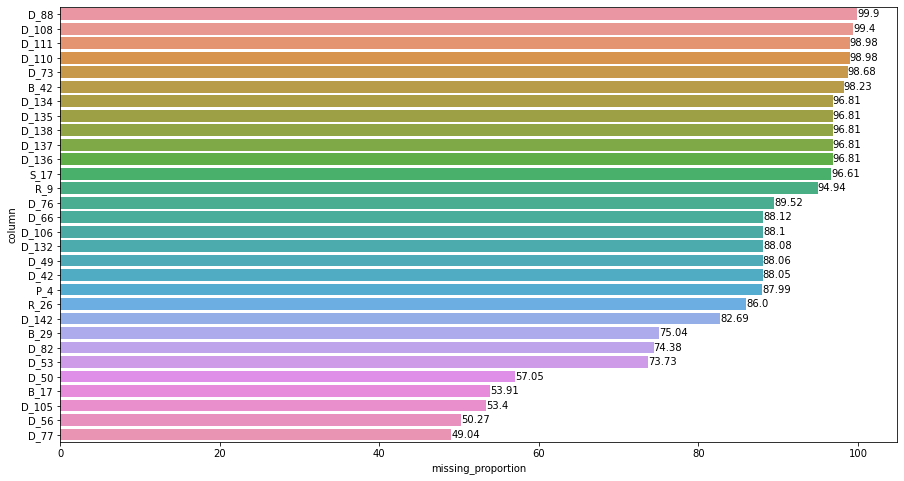

In [10]:
number_df = test.select_dtypes(np.number) #.drop(columns="target")
missing_df = plot_missing_proportion_barchart(number_df)

In [11]:
to_ffill_columns = ['R_5', 'B_17', 'S_8', 'S_15', 'S_17', 'R_6', 'P_4', 'S_9', 'B_5', 'S_27', 'S_7', 'S_25', 'B_42', 
 'R_9', 'B_8', 'S_3', 'S_24', 'S_22', 'R_26', 'S_23', 'B_29', 'R_27']

In [12]:
to_ffill_columns = set(to_ffill_columns).intersection(set(missing_df["column"]))

In [13]:
len(to_ffill_columns)

19

In [14]:
%%time
for col in to_ffill_columns:
    print("Before Impute: ", col, "missing value", test[col].isnull().sum())
    test[col] = test.groupby("customer_ID")[col].apply(lambda x: x.ffill().bfill())
    print("After Impute: ", col, "missing value", test[col].isnull().sum(), end="\n\n")

Before Impute:  S_8 missing value 3425261
After Impute:  S_8 missing value 1212742

Before Impute:  S_3 missing value 1740965
After Impute:  S_3 missing value 990538

Before Impute:  B_29 missing value 8527163
After Impute:  B_29 missing value 5311739

Before Impute:  S_22 missing value 61208
After Impute:  S_22 missing value 1027

Before Impute:  R_26 missing value 9773216
After Impute:  R_26 missing value 9311327

Before Impute:  B_8 missing value 104340
After Impute:  B_8 missing value 61028

Before Impute:  S_15 missing value 3262532
After Impute:  S_15 missing value 1181523

Before Impute:  S_23 missing value 1541
After Impute:  S_23 missing value 14

Before Impute:  P_4 missing value 9998768
After Impute:  P_4 missing value 9322295

Before Impute:  S_27 missing value 2500275
After Impute:  S_27 missing value 1219211

Before Impute:  S_7 missing value 1740965
After Impute:  S_7 missing value 990538

Before Impute:  S_24 missing value 60156
After Impute:  S_24 missing value 993

Be

In [9]:
gc.collect()

54

In [9]:
# test.to_parquet(f"./test_.parquet")

In [21]:
# temp = read_file("../../submissions/empty.csv")

In [23]:
test["customer_ID"] = test_["customer_ID"].values
del test_

In [26]:
test = test.reindex(columns=["customer_ID"]+list(test.columns[:-1]))

In [9]:
test.head()

,customer_ID,S_2,P_2,S_3,P_3,S_5,S_6,S_7,S_8,S_9,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.63,0.16,NaN,0.0,1,0.10,0.32,0.01,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.58,0.24,NaN,0.0,1,0.16,0.17,0.01,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.60,0.26,NaN,0.0,0,0.21,0.17,0.02,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.61,0.18,NaN,0.0,0,0.19,0.17,0.01,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.59,0.18,0.59,0.0,0,0.20,0.32,0.01,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0


In [8]:
%%time
# train_agg = feature_gen_pipeline(train)
test_agg = feature_gen_pipeline(test)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:36<00:00,  4.87it/s]

CPU times: user 1min 34s, sys: 1min 39s, total: 3min 13s
Wall time: 4min 21s


In [21]:
train_agg["target"] = labels["target"].values

In [22]:
sys.getsizeof(train_agg) / 1e9, train_agg.shape

(11.419067786, (458913, 4082))

In [9]:
sys.getsizeof(test_agg) / 1e9, test_agg.shape

(34.500922977, (924621, 4797))

In [10]:
del test

In [25]:
test_agg.to_pickle(f"./test_agg2.pkl")

In [6]:
test_agg = read_file(f"./test_agg.pkl")

Shape of data: (924621, 4797)


In [8]:
if "num_statements" in test_agg.columns:
    test_agg = test_agg.drop(columns=["num_statements"])

In [14]:
columns = get_cols(test_agg, ["_ma2_r2", "_ma2_r3", "_ma2_first", "_third_last"])

In [18]:
selected_columns = [col for col in test_agg.columns if col not in columns and col not in NON_FEATURE_COLUMNS]

In [20]:
test_agg.columns

Index(['P_2_last', 'S_3_last', 'P_3_last', 'S_5_last', 'S_6_last', 'S_7_last',
       'S_8_last', 'S_9_last', 'S_11_last', 'S_12_last',
       ...
       'D_137_velocity', 'D_137_sprint', 'D_137_previous_sprint',
       'D_137_acceleration', 'D_137_last_minus_avg', 'D_137_coef_var',
       'D_137_ma3_r1_r2', 'D_137_ma2_r1_r2', 'D_137_ma2_r1_r3',
       'D_137_general_trend'],
      dtype='object', length=4796)

In [22]:
len(selected_columns)

4081

In [23]:
%%time
test_agg = test_agg.loc[:, selected_columns]

CPU times: user 1.32 s, sys: 10 s, total: 11.3 s
Wall time: 33.5 s


In [24]:
test_agg.shape

(924621, 4081)

In [23]:
train_agg.to_pickle(f"./train_agg.pkl")

In [9]:
del train_agg, train

NameError: name 'train_agg' is not defined

In [26]:
# %%time
# test = read_file(f"../{INTERIM_TEST_PARQUET_PATH}/v1/test_parquet/test_all_variables.parquet")

In [ ]:
sys.getsizeof(test) / 1e9

NameError: name 'test' is not defined

In [ ]:
test.dtypes.value_counts()

In [ ]:
for col in to_ffill_columns:
    print("Before Impute: ", col, "missing value", test[col].isnull().sum())
    test[col] = test.groupby("customer_ID")[col].apply(lambda x: x.ffill().bfill())
    print("After Impute: ", col, "missing value", test[col].isnull().sum(), end="\n\n")

In [ ]:
%%time
test_agg = feature_gen_pipeline(test)

In [ ]:
sys.getsizeof(test_agg) / 1e9, test_agg.shape

In [ ]:
test_agg.to_pickle(f"./test_agg.pkl")

In [ ]:
del test_agg, test

In [ ]:
END = time.time()

In [ ]:
print(f"{END - START:.2f} seconds elapsed")